In [ ]:
# Exploratory Data Analysis

In [18]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, udf

In [4]:
# init spark session
spark = SparkSession.builder.master('local[*]').config('spark.ui.port', '4040').getOrCreate()

In [48]:
review_fp = "preprocessed/part-00000-9225e89c-df19-4685-83b9-d233cd6c1830-c000.csv"
df = spark.read.csv(review_fp, header=True, inferSchema=True)

df.printSchema()
print(f'Total reviews: {df.count()}')
df.show(5)

root
 |-- review: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- place_index: integer (nullable = true)
 |-- sentiment: string (nullable = true)

Total reviews: 3425
+--------------------+------+-----------+---------+
|              review|rating|place_index|sentiment|
+--------------------+------+-----------+---------+
|3 miếng gà 105k n...|     1|          0| negative|
|Gà ướp vừa vị , m...|     5|          0| positive|
|Thật tuyệt với gà...|     5|          0| positive|
|Quán sạch , đẹp ,...|     5|          0| positive|
|Nhân_viên bự con ...|     5|          0| positive|
+--------------------+------+-----------+---------+
only showing top 5 rows



In [49]:
# Total Rows & Columns

print(f"Total rows: {df.count()}")
print(f"Total columns: {len(df.columns)}")

Total rows: 3425
Total columns: 4


In [50]:
df.describe().show()

+-------+--------------------+------------------+-----------------+---------+
|summary|              review|            rating|      place_index|sentiment|
+-------+--------------------+------------------+-----------------+---------+
|  count|                3425|              3425|             3425|     3425|
|   mean|                NULL| 4.258978102189781|8.811678832116788|     NULL|
| stddev|                NULL|1.4544572187638496|5.209891653545296|     NULL|
|    min|( không chỉ chi_n...|                 1|                0| negative|
|    max|               🥳 🙌|                 5|               17| positive|
+-------+--------------------+------------------+-----------------+---------+



In [51]:
df.groupBy('rating').count().orderBy('rating').show()

+------+-----+
|rating|count|
+------+-----+
|     1|  496|
|     2|   68|
|     3|  113|
|     4|  124|
|     5| 2624|
+------+-----+



In [52]:
# Missing values

df.select([col(c).isNull().alias(c) for c in df.columns]).groupBy().sum().show()

++
||
++
||
++



In [53]:
df.select('place_index').distinct().count()

18

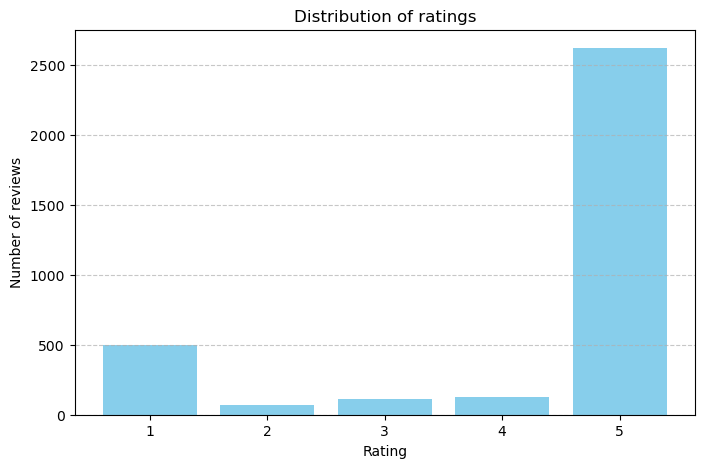

In [54]:
# Distribution of ratings

import matplotlib.pyplot as plt

rating_distribution = df.groupBy('rating').count().orderBy('rating')

data = rating_distribution.collect()
ratings = [row['rating'] for row in data]
counts = [row['count'] for row in data]

plt.figure(figsize=(8, 5))
plt.bar(ratings, counts, color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Number of reviews')
plt.title('Distribution of ratings')
plt.xticks(ratings)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

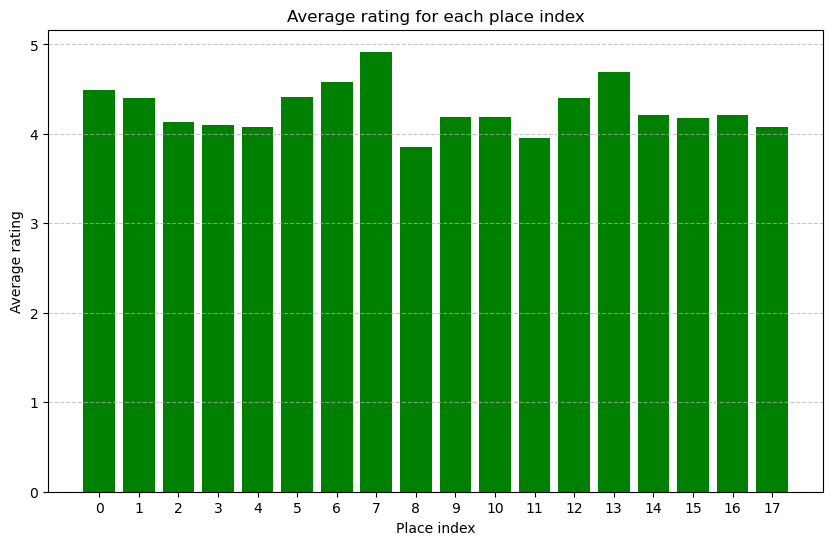

In [56]:
#'place_index' by average rating

place_index_rating_avg = df.groupBy('place_index').avg('rating').orderBy('place_index')

data = place_index_rating_avg.collect()
place_indices = [row['place_index'] for row in data]
avg_ratings = [row['avg(rating)'] for row in data]

plt.figure(figsize=(10, 6))
plt.bar(place_indices, avg_ratings, color='green')
plt.xlabel('Place index')
plt.ylabel('Average rating')
plt.title('Average rating for each place index')
plt.xticks(place_indices)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Word Count

In [112]:
stopwords_path = "preprocessed/vietnamese-stopwords-dash.txt"
with open(stopwords_path, 'r', encoding='utf-8') as f:
    stopwords = [line.strip() for line in f.readlines()]

In [122]:
from pyspark.sql.functions import explode, split, lower, regexp_replace, col, desc, length

df_clean = df.withColumn(
    "clean_review",
    regexp_replace(
        lower(col("review")),
        "[^a-zA-Z\\sàáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữỳýỵỷỹđ]",
        ""
    )
)

word_counts = df_clean.select(
    explode(split(col("clean_review"), " ")).alias("word")
).filter(
    (col("word") != "") &
    (~col("word").isin(stopwords))
).groupBy("word").count().orderBy(desc("count"))

In [115]:
print("Top các từ phổ biến nhất:")
word_counts.show(50, truncate=False)

Top các từ phổ biến nhất:
+---------+-----+
|word     |count|
+---------+-----+
|nhânviên |1587 |
|ngon     |1305 |
|gà       |938  |
|đồ       |836  |
|nhiệttình|660  |
|phụcvụ   |556  |
|món      |427  |
|kfc      |395  |
|thânthiện|370  |
|quán     |366  |
|dễthương |363  |
|khônggian|289  |
|sạchsẽ   |274  |
|ko       |258  |
|k        |243  |
|đi       |233  |
|giòn     |233  |
|tháiđộ   |208  |
|tệ       |185  |
|mua      |185  |
|đợi      |177  |
|nóng     |172  |
|nv       |171  |
|nhàhàng  |171  |
|dịchvụ   |154  |
|ghé      |153  |
|nghiệm   |151  |
|vuivẻ    |145  |
|trải     |140  |
|nha      |138  |
|đơn      |134  |
|lắm      |134  |
|hơi      |131  |
|order    |131  |
|thoáng   |128  |
|mát      |128  |
|kháchhàng|127  |
|chinhánh |124  |
|miếng    |123  |
|giao     |122  |
|ok       |120  |
|rán      |117  |
|đông     |114  |
|quảnlý   |113  |
|combo    |113  |
|gọi      |109  |
|tuyệtvời |104  |
|chỗ      |100  |
|mấy      |100  |
|chiên    |97   |
+---------+-----+
on

In [91]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 3.5 MB/s eta 0:00:00a 0:00:01


In [ ]:
# Word Cloud

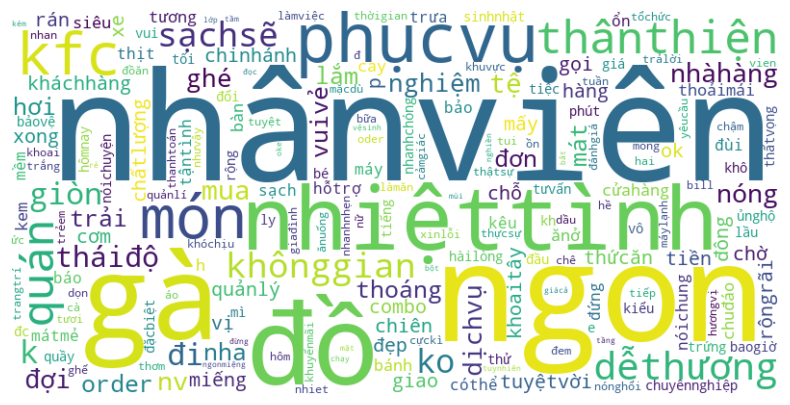

In [118]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_counts_data = word_counts.collect()
word_freq = {row['word']: row['count'] for row in word_counts_data}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [126]:
word_counts_by_sentiment = df_clean.select(
    explode(split(col("clean_review"), " ")).alias("word"),
    col("sentiment")
).filter(
    (col("word") != "") & 
    (~col("word").isin(stopwords))
).groupBy("sentiment", "word").count().orderBy("sentiment", F.desc("count"))

word_counts_by_sentiment.show(50, truncate=False)


+---------+---------+-----+
|sentiment|word     |count|
+---------+---------+-----+
|negative |nhânviên |368  |
|negative |gà       |339  |
|negative |ko       |194  |
|negative |k        |182  |
|negative |tệ       |169  |
|negative |tháiđộ   |166  |
|negative |đồ       |155  |
|negative |kfc      |149  |
|negative |đợi      |144  |
|negative |món      |135  |
|negative |đi       |127  |
|negative |quán     |126  |
|negative |mua      |119  |
|negative |đơn      |113  |
|negative |giao     |99   |
|negative |order    |96   |
|negative |phụcvụ   |84   |
|negative |gọi      |84   |
|negative |xong     |78   |
|negative |p        |78   |
|negative |miếng    |77   |
|negative |chinhánh |74   |
|negative |kháchhàng|72   |
|negative |combo    |72   |
|negative |tiền     |72   |
|negative |chiên    |66   |
|negative |nv       |66   |
|negative |h        |65   |
|negative |quảnlý   |63   |
|negative |chờ      |61   |
|negative |hàng     |57   |
|negative |tương    |57   |
|negative |khoaitây 

In [127]:
word_counts_by_rating = df_clean.select(
    explode(split(col("clean_review"), " ")).alias("word"),
    col("rating")
).filter(
    (col("word") != "") & 
    (~col("word").isin(stopwords))  # Lọc stopwords
).groupBy("rating", "word").count().orderBy("rating", F.desc("count"))

word_counts_by_rating.show(50, truncate=False)


+------+---------+-----+
|rating|word     |count|
+------+---------+-----+
|1     |nhânviên |328  |
|1     |gà       |279  |
|1     |ko       |182  |
|1     |k        |164  |
|1     |tệ       |154  |
|1     |tháiđộ   |143  |
|1     |đồ       |131  |
|1     |đợi      |130  |
|1     |kfc      |124  |
|1     |món      |120  |
|1     |quán     |113  |
|1     |đơn      |109  |
|1     |đi       |104  |
|1     |mua      |104  |
|1     |order    |91   |
|1     |giao     |86   |
|1     |phụcvụ   |76   |
|1     |p        |72   |
|1     |xong     |70   |
|1     |gọi      |69   |
|1     |miếng    |68   |
|1     |chinhánh |66   |
|1     |tiền     |66   |
|1     |combo    |62   |
|1     |kháchhàng|60   |
|1     |quảnlý   |59   |
|1     |chiên    |59   |
|1     |chờ      |58   |
|1     |h        |57   |
|1     |kêu      |53   |
|1     |đứng     |50   |
|1     |hàng     |49   |
|1     |tương    |48   |
|1     |khoaitây |48   |
|1     |nghiệm   |47   |
|1     |nv       |46   |
|1     |cơm      |44   |
